In [ ]:
!pip install -q backports.cached-property keras-unet segmentation_models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%env SM_FRAMEWORK=tf.keras
import json
import os
import pathlib
import json

from datetime import datetime
from enum import Enum
from glob import glob
from math import ceil

import numpy as np
import sklearn as sk
import sklearn.model_selection
import cv2 as cv
import tensorflow as tf
import tensorflow.keras as kr
#import keras_segmentation as krs
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
import segmentation_models as sm

# for retrocompatibility if python version is less than 3.8
try:
    from functools import cached_property
except ImportError:
    from backports.cached_property import cached_property

from typing import Tuple, List, Dict, Any, Callable, Union, Iterator, Iterable

env: SM_FRAMEWORK=tf.keras


In [ ]:
print("tensorflow version: {}".format(tf.__version__))
print("keras version: {}".format(kr.__version__))
print("available gpu: {}".format(tf.test.gpu_device_name()))

tensorflow version: 2.3.0
keras version: 2.4.0
available gpu: 


In [ ]:
SEED = abs(hash("cookies")) // 2**32
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
PREPROCESSING_MASK_LIMITS_HSV = ((30,40,70), (80,255,255))
BS = 4
IMAGE_SIZE = (256,256)
EPOCHS = 50
EPOCHS_FINE = 30

In [ ]:
PATH_DATA = pathlib.Path("./drive/MyDrive/Development_Dataset")

PATH_WORKING = pathlib.Path("./drive/MyDrive")

PATH_TRAINING = PATH_DATA / "Training"

PATH_TEST = PATH_DATA / "Test_Dev"

PATH_EXPERIMENT = PATH_WORKING / datetime.now().strftime("%m-%d_%H-%M")

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
def show(*args):
    s = 10
    _, axs = plt.subplots(1, len(args), figsize=(s*len(args),s*1.6))
    
    for i in range(len(args)):
        axs[i].imshow(args[i])
        #plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
import time
class Timer:
    def __init__(self):
        self._begin = 0.
        self._last = 0.
    def start(self):
        self._begin = time.perf_counter()
        self._last = self._begin
        return self
    def check(self):
        l, self._last = self._last, time.perf_counter()
        return self._last - l
    def pcheck(self, name="from last checkpoint"):
        pass
        print("{} {}s".format(name,self.check()))
timer = Timer()

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
    _seed = SEED

    def __init__(self,
                 paths_images: List[str],
                 paths_masks: List[str] = None,
                 image_data_generator_options: Dict = None,
                 preprocessing_function: Callable[[np.array], np.array] = lambda x: x,
                 postprocessing_function: Callable[[np.array], np.array] = lambda x: x,
                 mask_decoding_function: Callable[[np.array], np.array] = lambda x: x,
                 image_size: Tuple[int, int] = [256, 256],
                 batch_size: int = 8,
                 shuffle: bool = False
                ):
        '''
        :param paths_images: A list of images' paths
        :param paths_masks: The list of corresponding masks' paths or None if this is a prediction dataset
        :param image_generator: A generator for images augmentation
        :param preprocessing_function: The preprocessing function is applies to the images before augumentation and resizing phases
        :param postprocessing_function: The postprocessing function is applies to the images after the augmentation and resizing phases
        :param image_size: The output image's size
        :param mask_decoding_function: The decoding function is used to deconding mask files
        :param batch_size: The maximum size of each batch
        :param shuffle: If it is True at each epoch the data are shuffled
        '''
        self._paths_images = paths_images
        self._paths_masks = paths_masks
        self._image_size = image_size
        self._preprocessing_function = preprocessing_function
        self._postprocessing_function = postprocessing_function
        self._mask_decoding_function = mask_decoding_function
        self._batch_size = batch_size
        self._shuffle = shuffle
        
        self._transform_generator = self._get_transform_generator()
        
        self._indexes = np.arange(len(paths_images))
        if self._shuffle:
            np.random.shuffle(self._indexes)
        
        self._image_data_generator = None
        self._mask_data_generator = None
        if image_data_generator_options is not None:
            self._image_data_generator = kr.preprocessing.image.ImageDataGenerator(**image_data_generator_options)
            image_data_generator_options["fill_mode"]="nearest"
            self._mask_data_generator = kr.preprocessing.image.ImageDataGenerator(**image_data_generator_options)

    def __len__(self):
        if self._batch_size == 0:
            return 1
        
        return ceil(len(self._paths_images) / self._batch_size)

    def __getitem__(self, batch_index: int) -> Union[np.array, Tuple[np.array, np.array]]:
        data=[]
        
        batch_indexes = self._indexes if self._batch_size == 0 else self._indexes[batch_index * self._batch_size:(1 + batch_index) * self._batch_size]
        
        for i in batch_indexes:
            if len(self._indexes) <= i:
                break
            
            data.append(self._get_data(i))
            
        if self._paths_masks is None:
            return np.array(data)
        
        images, masks = zip(*data)
            
        return np.array(images), np.array(masks)    
    
    def _get_data(self, index: int) -> Union[np.array, Tuple[np.array, np.array]]:
        #timer.start()
        
        image = plt.imread(self._paths_images[index], np.uint8)#, cv.IMREAD_COLOR)
        #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        #image = image.astype(np.float)
        
        # loads the image from file
        #image = kr.preprocessing.image.load_img(self._paths_images[index],color_mode="rgb",)
        #timer.pcheck("img load")
        
        # converts the image in a numpy array
        #image = kr.preprocessing.image.img_to_array(image, dtype=np.float)
        #timer.pcheck("img arr_conv")
        
        # applies the preprocessing function to the image
        image = self._preprocessing_function(image)
        #timer.pcheck("img pre")
        
        # resizes image
        image = cv.resize(image, self._image_size, cv.INTER_LINEAR)
        #timer.pcheck("img resize")

        transf_image, transf_mask = None, None
        if self._image_data_generator is not None:
            # gets a transformation
            transf_image, transf_mask = next(self._transform_generator)

            # applies the transformation to mask and image
            image = self._image_data_generator.apply_transform(image, transf_image)
        #timer.pcheck("img aug")
        
        # applies postprocessing function to the image
        image = self._postprocessing_function(image)
        #timer.pcheck("img post")
        
        # forces the images output type
        #image = image.astype(np.uint8)
        #timer.pcheck("img cast")
        
        if self._paths_masks is None:
            return image     
        
        mask = plt.imread(self._paths_masks[index], np.uint8)
        # loads the mask from file
        #mask = kr.preprocessing.image.load_img(self._paths_masks[index], color_mode="rgb")
        
        # converts the mask in a numpy array
        # dtype uint8 does not allow image augumentation to interpolate pixels
        #mask = kr.preprocessing.image.img_to_array(mask, dtype=np.uint8)
        #timer.pcheck("mask load")
        
        # if provided apply the mask decoding function
        mask = self._mask_decoding_function(mask)
        #timer.pcheck("mask dec")
        
        # resizes the mask
        mask = cv.resize(mask, self._image_size, interpolation=cv.INTER_NEAREST)
        #timer.pcheck("mask res")
        
        if transf_mask is not None:
            # applies the transformation to mask
            mask = self._mask_data_generator.apply_transform(mask, transf_mask)
            
            # removes the error given by interpolation
            mask = np.round(mask)
        #timer.pcheck("mask aug")
        
        # force the mask output type
        mask = mask.astype(np.float)
        #timer.pcheck("mask cast")
        
        return image, mask
    
    def on_epoch_end(self) -> None:
        if self._shuffle:
            np.random.shuffle(self._indexes)

    def _get_transform_generator(self):
        # defines a generator to get repetable transformations
        while True:
            yield (self._image_data_generator.get_random_transform(self._image_size, seed=CustomDataset._seed), 
                    self._mask_data_generator.get_random_transform(self._image_size, seed=CustomDataset._seed))
            CustomDataset._seed += 1

In [ ]:
class MaskDecoding:
    """
    Provides the function to decode the mask files
    """
    def __init__(self, include_ground: bool = True, merge_channels: bool = False):
        self._include_ground = include_ground
        self._merge_channels = merge_channels
        
        assert (not (self._include_ground and self._merge_channels)), "include_ground and merge_channels both True will not give the expected result"
        
    def __call__(self, mask: np.array) -> np.array:
        channels = [
            np.all(mask==[255,255,255],axis=2)[:,:,np.newaxis],
            np.all(mask==[216, 67, 82],axis=2)[:,:,np.newaxis]
        ]
        
        # if required creates a new first channel with ground and others background 
        if self._include_ground:
            channels += [np.logical_or(np.all(mask==[0,0,0],axis=2), np.all(mask==[254,124,18],axis=2))[:,:,np.newaxis]]
        
        # create a single matrix with all the channels
        mask = np.concatenate(channels, axis=2)
        
        # if required merges all the channels in one, with an unique value for each original channel
        if self._merge_channels:
            # generates a new array with the same size of the original mask 
            new_mask = np.zeros((*mask.shape[0:2],1), dtype=np.float)

            # adds channels to new array on a single channel
            for i in range(mask.shape[-1]):
                new_mask[:,:,0] += mask[:,:,i] * (i + 1)

            mask = new_mask

        return mask.astype(dtype=np.float)

In [ ]:
# defines the images' paths
PATHS_TRAINING_IMAGES = [
    *list((PATH_TRAINING / "Bipbip" / "Mais" / "Images").rglob("*.jpg")),
    #*list((PATH_TRAINING / "Roseau" / "Mais" / "Images").rglob("*.png")),
    #*list((PATH_TRAINING / "Weedelec" / "Mais" / "Images").rglob("*.jpg"))
]

# retieves the corresponding masks' paths
PATHS_TRAINING_MASKS = [f.parents[1] / "Masks" / (f.stem + ".png") for f in PATHS_TRAINING_IMAGES]

# retrieves test images
PATHS_TEST = [
    *list(PATH_TEST.rglob("*.jpg")),
    *list(PATH_TEST.rglob("*.png"))
]

In [ ]:
print("Found {} training images".format(len(PATHS_TRAINING_IMAGES)))
print("Found {} test images".format(len(PATHS_TEST)))

Found 90 training images
Found 120 test images


In [ ]:
def preprocessing_image(image: np.array) -> np.array:
    image_hsv = cv.cvtColor(image.astype(np.uint8), cv.COLOR_RGB2HSV)

    designed_mask = cv.inRange(image_hsv, *PREPROCESSING_MASK_LIMITS_HSV)

    denoised_mask = cv.morphologyEx(designed_mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT, (7,7)))

    dilatated_mask = cv.dilate(denoised_mask, np.ones((11,11),np.uint8), iterations = 5)

    image_masked = cv.bitwise_and(image, image, mask = dilatated_mask)

    return image_masked

In [ ]:
generator_options = dict(
                rotation_range=20,
                zoom_range=0.15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.15,
                horizontal_flip=True,
                fill_mode="constant"
            )

# splits training and validation
dataset = sk.model_selection.train_test_split(PATHS_TRAINING_IMAGES,
                                              PATHS_TRAINING_MASKS,
                                              test_size=0.20,
                                              random_state=SEED)

# creates the training and validation dataset
ds_training = CustomDataset(
    dataset[0],
    dataset[2],
    image_data_generator_options=generator_options,
    #preprocessing_function=preprocessing_image,
    #postprocessing_function=preprocess_input,
    mask_decoding_function=MaskDecoding(include_ground=True, merge_channels=False),
    image_size=IMAGE_SIZE,
    batch_size=BS,
    shuffle=True
)
ds_validation = CustomDataset(
    dataset[1],
    dataset[3],
    image_data_generator_options=generator_options,
    #preprocessing_function=preprocessing_image,
    #postprocessing_function=preprocess_input,
    mask_decoding_function=MaskDecoding(include_ground=True),
    image_size=IMAGE_SIZE,
    batch_size=BS,
    shuffle=True
)
# creates the test dataset
ds_test = CustomDataset(
    PATHS_TEST,
    #preprocessing_function=preprocessing_image,
    #postprocessing_function=preprocess_input,
    image_size=IMAGE_SIZE,
    batch_size=5
)

print("{} images for training".format(len(dataset[0])))
print("{} images for validation".format(len(dataset[1])))
print("{} images to test".format(len(PATHS_TEST)))

72 images for training
18 images for validation
120 images to test


In [ ]:
%%script false --no-raise-error
ds = CustomDataset(
    dataset[0],
    dataset[2],
    image_generator=generator,
    preprocessing_function=preprocessing_image,
    postprocessing_function=preprocess_input,
    mask_decoding_function=MaskDecoding(include_ground=False, merge_channels=False),
    image_size=IMAGE_SIZE,
    batch_size=5,
    shuffle=True
)
N=10
t = Timer().start()
for i in range(N):
    ds_training[i]
print("average time to load a batch {}s".format(t.check()/N))

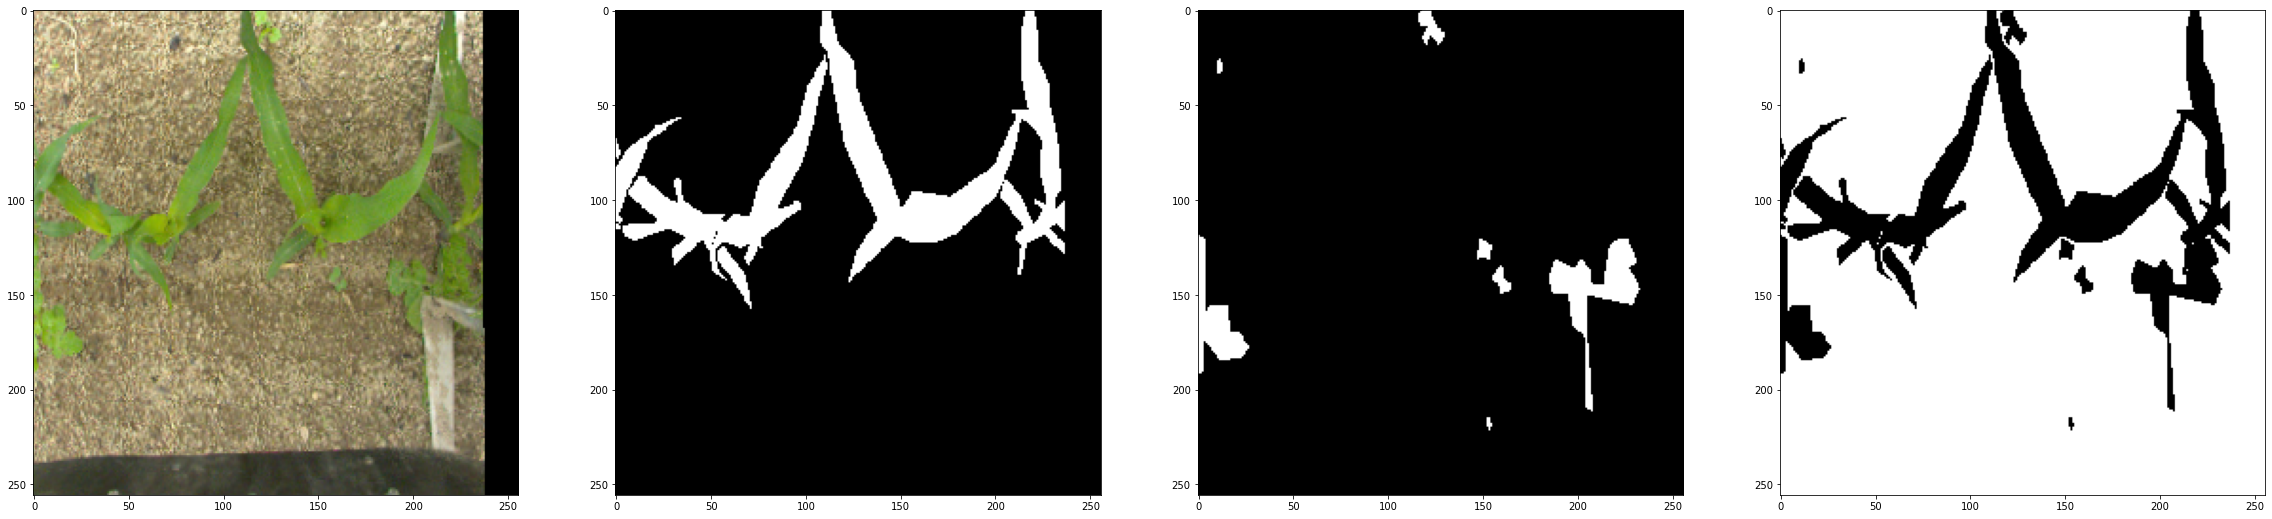

In [ ]:
images, masks = ds_training[0]
show(images[0], masks[0,...,-3], masks[0,...,-2], masks[0,...,-1])

In [ ]:
class MeanIoU:
    __name__ = "MeanIoU"
    def __init__(self, number_categories: int, include_zero: bool = True):
        self._number_categories = number_categories
        self._include_zero = include_zero
        
        self._categories_indexes = list(range(0 if include_zero else 1,number_categories))
        
    def __call__(self, y_true, y_pred):
        y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)

        inters = y_true * y_pred
        union = y_true + y_pred - inters

        return tf.reduce_mean([tf.reduce_sum(inters[:,:,:,i]) / tf.reduce_sum(union[:,:,:,i]) for i in self._categories_indexes])

In [ ]:
class DisplayCallback(kr.callbacks.Callback):
    def __init__(self):
        pass
    def on_epoch_end(self, epoch, logs=None):
        pass
    
class TimeCallback(kr.callbacks.Callback):
    pass

In [ ]:
def get_callbacks(
                  save_model: bool = True,
                  checkpoints: bool = False,
                  tensorboard: bool = True,
                  early_stopping: bool = True
                  ):    
    # returns a list of desidered callbacks for the fit process
    callbacks = []
    
    if save_model:
        os.makedirs(PATH_EXPERIMENT / "model", exist_ok=True)
        callbacks.append(kr.callbacks.ModelCheckpoint(str(PATH_EXPERIMENT / "model"), save_best_only=True, mode='min'))

    if checkpoints:
        # if they are requesed, checkpoints will be saved in a specific experiment subdirecotry
        os.makedirs(PATH_EXPERIMENT / "checkpoints", exist_ok=True)

        callbacks.append(kr.callbacks.ModelCheckpoint(
            str(PATH_EXPERIMENT / "checkpoints" / "cp-{epoch:04d}.ckpt")
        ))

    if tensorboard:
        # if they are required, tensorboard files will be generated
        os.makedirs(PATH_EXPERIMENT / "tb_log", exist_ok=True)

        callbacks.append(kr.callbacks.TensorBoard(
            PATH_EXPERIMENT / "tb_log",
            histogram_freq=1,
            profile_batch=0
        ))
    if early_stopping:
        callbacks.append(kr.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ))

    return callbacks

In [ ]:
preprocessing = sm.get_preprocessing("resnet34")
ds_training._postprocessing_function = preprocessing
ds_validation._postprocessing_function = preprocessing
ds_test._postprocessing_function = preprocessing

In [ ]:
model = sm.Unet('resnet34', encoder_weights='imagenet', classes=3, activation="softmax", input_shape=(*IMAGE_SIZE, 3))

# define optomizer
optim = kr.optimizers.Adam(1e-4)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
_______________________________________________________________________________________

In [ ]:
%%script false --no-raise-error
from keras_unet.models import custom_unet

from keras import backend as K
def depth_softmax(matrix):

    exp_matrix = K.exp(matrix)
    softmax_matrix = exp_matrix / K.expand_dims(K.sum(exp_matrix, axis=-1), axis=-1)
    return softmax_matrix

base_model = custom_unet(
    input_shape=(*IMAGE_SIZE, 3),
    use_batch_norm=False,
    num_classes=3,
    filters=64,
    dropout=0.2,
    output_activation="softmax"
)
#model.summary()

# output = kr.layers.Lambda(depth_softmax)(model)
# output = Deconvolution2D(3, 1, 1, border_mode='same', output_shape=(3,*IMAGE_SIZE))(output)
# output = Permute(2,3,1)(output)
#output = kr.layers.BatchNormalization()(model.output)
output = kr.layers.Lambda(depth_softmax)(base_model.output)

model = kr.models.Model(base_model.inputs, output)

model.summary()

In [ ]:
%%script false --no-raise-error
model = krs.pretrained.pspnet_50_ADE_20K()
#.Unet(encoder_weights='imagenet', classes=2, activation="sigmoid", encoder_freeze=True)
model = krs.models.unet.vgg_unet(n_classes=2, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], )
model.summary()

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

for layer in vgg.layers:
    layer.trainable = False
    
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    return model

model = create_model(depth=8, 
                     start_f=32, 
                     num_classes=2)

model.summary()

In [ ]:
%%script false --no-raise-error
model.compile(
    optimizer=kr.optimizers.Adam(lr=1e-3, decay=1e-3 / EPOCHS), 
    #optimizer=kr.optimizers.SGD(lr=0.01, momentum=0.99),
    #loss=tf.keras.metrics.BinaryAccuracy(threshold=0.5),
    #loss=tf.keras.losses.BinaryCrossentropy(),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=kr.losses.CategoricalCrossentropy(),
    #loss=jaccard_distance,
    metrics=[
        #'accuracy',
        kr.metrics.MeanIoU(3),
        MeanIoU(3, include_zero=False),
        #tf.keras.metrics.BinaryAccuracy(threshold=0.5),
        #mean_iou,
        #tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)

In [ ]:
training_history = model.fit(
    ds_training,
    validation_data=ds_validation,
    epochs=EPOCHS,
    callbacks=get_callbacks(),
    #use_multiprocessing=True,
    #workers=mp.cpu_count()
)

Epoch 1/50
18/18 [==============================] - 139s 8s/step - loss: 0.8729 - iou_score: 0.2581 - f1-score: 0.3205 - val_loss: 0.8600 - val_iou_score: 0.2223 - val_f1-score: 0.2665
Epoch 2/50
18/18 [==============================] - 117s 6s/step - loss: 0.8118 - iou_score: 0.3768 - f1-score: 0.4737 - val_loss: 0.8672 - val_iou_score: 0.1853 - val_f1-score: 0.2395
Epoch 3/50
18/18 [==============================] - 138s 8s/step - loss: 0.7466 - iou_score: 0.5288 - f1-score: 0.6406 - val_loss: 0.8222 - val_iou_score: 0.3626 - val_f1-score: 0.4769
Epoch 4/50
18/18 [==============================] - 137s 8s/step - loss: 0.6782 - iou_score: 0.6187 - f1-score: 0.7350 - val_loss: 0.7832 - val_iou_score: 0.4998 - val_f1-score: 0.6300
Epoch 5/50
18/18 [==============================] - 137s 8s/step - loss: 0.6278 - iou_score: 0.6508 - f1-score: 0.7634 - val_loss: 0.7487 - val_iou_score: 0.6010 - val_f1-score: 0.7258
Epoch 6/50
18/18 [==============================] - 136s 8s/step - loss: 0.

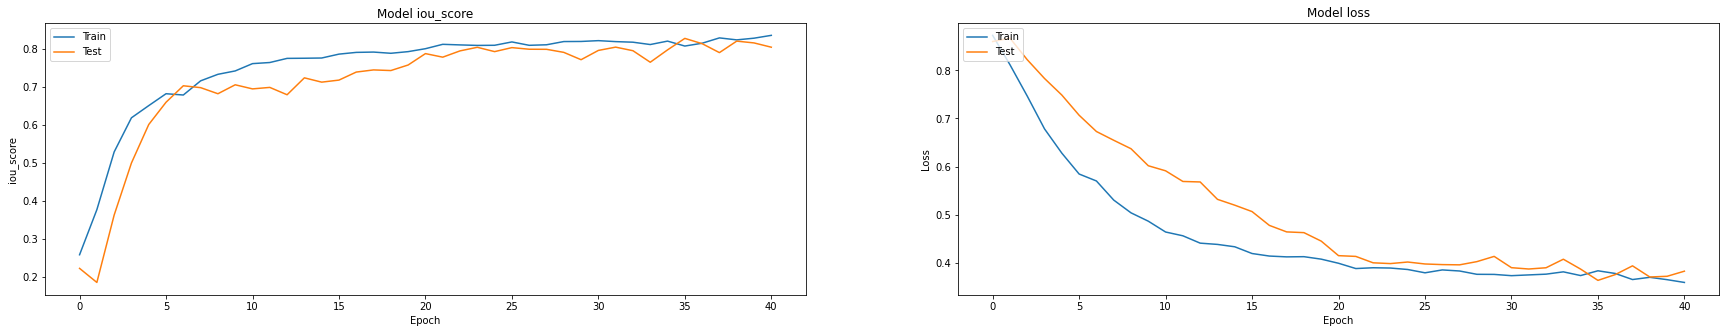

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(training_history.history['iou_score'])
plt.plot(training_history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
%%script false --no-raise-error
model.trainable = True

model.summary()

model.compile(
    optimizer=kr.optimizers.Adam(lr=1e-5, decay=1e-5 / EPOCHS_FINE),
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss=kr.losses.BinaryCrossentropy(),
    metrics=[
        meanIoU,
        #kr.metrics.BinaryAccuracy(threshold=0.5)
    ]
)

In [ ]:
%%script false --no-raise-error
model.fit(
    ds_training,
    validation_data=ds_validation,
    epochs=EPOCHS_FINE,
    steps_per_epoch=len(ds_training),
    validation_steps=len(ds_validation),
    callbacks=get_callbacks()
)

In [ ]:
test_output = model.predict(
    ds_test,
    #use_multiprocessing=True,
    #workers=mp.cpu_count()
)

In [ ]:
prediction = np.argmax(test_output,axis=-1)

crop = np.array(prediction == 0, dtype=np.uint8)
weed = np.array(prediction == 1, dtype=np.uint8)
ground = np.array(prediction == 2, dtype=np.uint8)

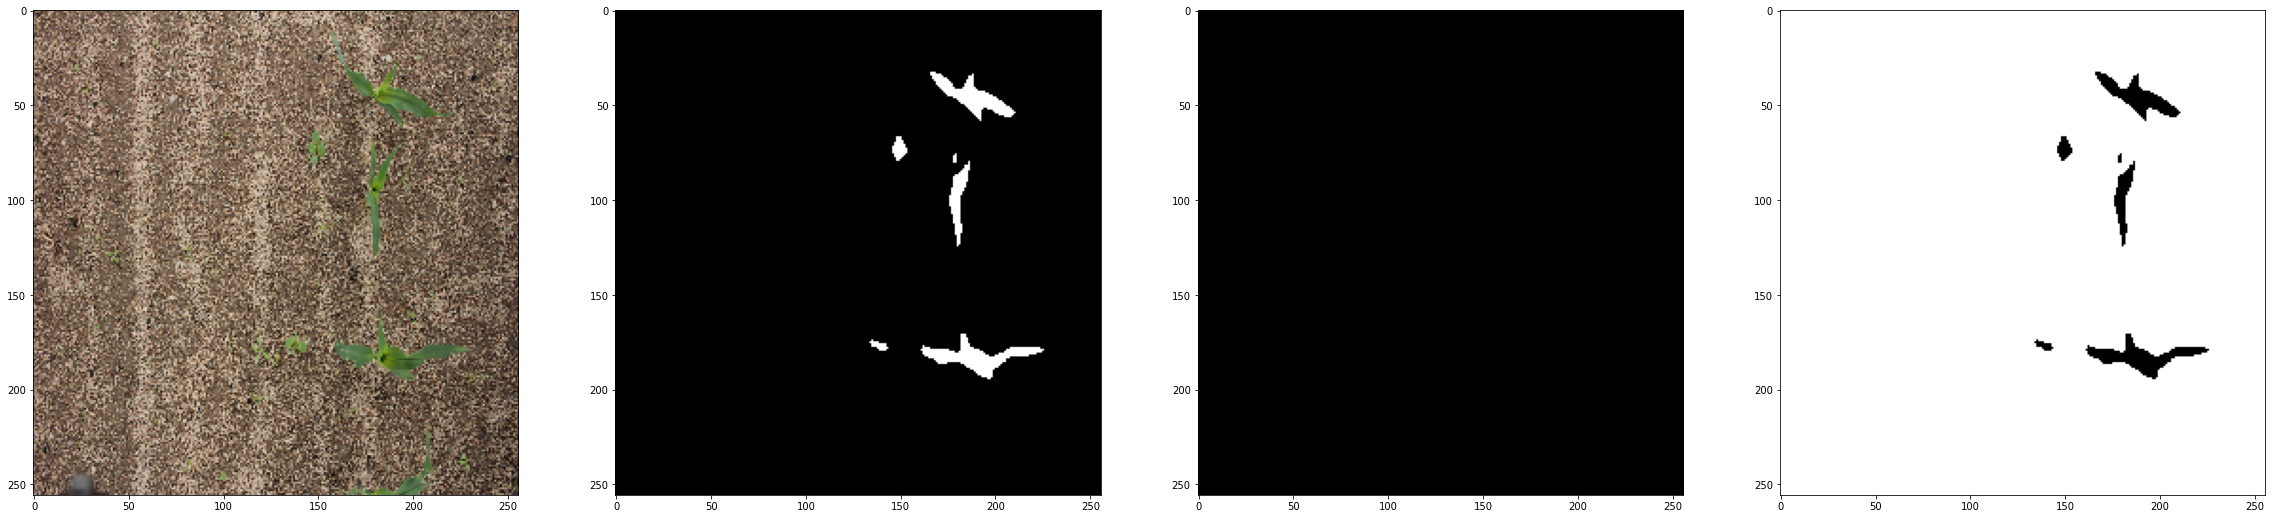

In [ ]:
show(ds_test[0][0], crop[0], weed[0], ground[0])

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
submission = {}
for i in range(len(PATHS_TEST)):
    path = PATHS_TEST[i]
    name = path.stem
    
    image_size = kr.preprocessing.image.load_img(path).size
    
    submission[name] = {
        "shape": image_size,
        "crop": PATHS_TEST[i].parents[1].stem,
        "team": PATHS_TEST[i].parents[2].stem,
        "segmentation": {
            "crop": rle_encode(cv.resize(crop[i,:,:], dsize=image_size, interpolation=cv.INTER_NEAREST)),
            "weed": rle_encode(cv.resize(weed[i,:,:], dsize=image_size, interpolation=cv.INTER_NEAREST))
        }
    }

with open("submission.json", "w") as file:
    json.dump(submission, file)

In [ ]:
!zip submission.zip submission.json

updating: submission.json (deflated 63%)
